# Stochastic Invasion of Variants of Concern

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from tqdm import tqdm
import numpy.linalg as nla
import seaborn as sns
import scipy as sp
import pandas as pd
import sympy as sym
from odeintw import odeintw

In [2]:
# =============================================================================
# Class for solving ODEs
# =============================================================================
class ODESolver:
    def __init__(self, f):
        self.f = f
    
    def advance(self):
        raise NotImplementedError
    
    def set_ic(self, u0):
        if not isinstance(u0, float):
            self.u0 = u0.astype(float)
        else:
            self.u0 = u0
    
    def solver(self, time_points):
        self.t = np.asarray(time_points)
        self.tlen = len(self.t)
        if isinstance(self.u0, float):
            self.numeqs=1
        else:
            self.numeqs = np.shape(self.u0)[0]
        self.u = np.zeros((self.numeqs, self.tlen))
        self.u[:,0] = self.u0
        for k in range(0,self.tlen-1):
            self.k=k
            self.u[:, k+1] = self.advance()
        return self.u, self.t
    

class ForwardEuler(ODESolver): # Runs faster than Runge Kutta
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        dt = t[k+1] - t[k]
        unew = u[:, k] + dt*f(u[:, k], t[k])
        return unew

class RungeKutta4(ODESolver): # Alternatively, can use Runge Kutta (may be preferable to Euler if inhomogeneous rates are particularly pathological)
    def advance(self):
        u, f, k, t = self.u, self.f, self.k, self.t
        numeqs = np.shape(u)[0]
        dt = t[k+1]-t[k]
        dt2 = dt/2.0
        unew = np.zeros(numeqs)
        
        K1 = dt*f(u[:, k], t[k])
        K2 = dt*f(u[:, k] + 0.5*K1, t[k]+dt2)
        K3 = dt*f(u[:, k] + 0.5*K2, t[k] + dt2)
        K4 = dt*f(u[:, k] + K3, t[k] + dt)
    
        unew = u[:, k] + (1/6.0)*(K1 + 2*K2 + 2*K3 + K4)
        return unew

In [3]:
# =============================================================================
# Class for extinction probability of multi-type branching process (MTBP)
# =============================================================================

class MTBP_extinct:
    # Set offspring distribution for the process - this defines the process
    def __init__(self, offspring):
        self.offspring = offspring
    
    # Set lifetimes for particles of each type
    def set_lifespans(self, omega):
        self.omega = omega
    
    def get_lifespans(self):
        return self.omega
    
    
    # Set a vector of immigration rates
    def set_immigration(self, eta):    
        self.eta = eta
    
    # Build ODEs for the probability of extinction of a process that begins with a single particle of each type, 
    # excluding immigration. The final equation includes immigration and describes the full process starting with a
    # vector of n0 particles of each type and immigration at rate eta. 
    
    def set_odes(self, u, t):
        omega = self.omega
        P = self.offspring
        eta = self.eta
        if isinstance(eta(t), float):
            self.numeqs=1
            deriv = np.zeros(self.numeqs + 1)
            deriv[0] = -omega(t)*u[0] + omega(t)*P(u[0:-1], t)[0]
            sumqs = eta(t)*u[0]
            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs
        else:
            self.numeqs = len(eta(t))
            sumqs = 0
            deriv = np.zeros(self.numeqs + 1)
            for i in range(0, self.numeqs):
                deriv[i] = -omega(t)[i]*u[i] + omega(t)[i]*P(u[0:-1], t)[i]

                sumqs += eta(t)[i]*u[i]

            deriv[-1] = -np.sum(eta(t))*u[-1] + u[-1]*sumqs

        return deriv

    def solve_odes(self, set_odes, t, ics, n0, methodclass=RungeKutta4, Full = False):
        method = methodclass(set_odes)
        method.set_ic(u0=ics)
        R, t = method.solver(time_points=t)
#         R = sp.integrate.odeint(set_odes, ics, time).T
        numqs = np.shape(R)[0] - 1
        tlen = len(t)
        Qprod = np.ones(tlen)
        r = R[-1,:]
        if Full:
            return R
        else:
            if isinstance(n0, float):
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0)
            else:
                for i in range(0, numqs):
                    Qprod *= R[i,:]**(n0[i])
            rho = r*Qprod
            sol = np.stack((Qprod, rho), axis=0)
            return sol
    
    def time_to_pextinct(self, t, p, sol):
        rho = sol[-1,:]
        numqs = np.shape(sol)[0] - 1
        q = np.ones_like(rho)
        for i in range(0, numqs):
            q*=sol[i, :]
        if isinstance(p, float):
            qwhere = np.where(q>=p)[0]
            rhowhere = np.where(rho>=p)[0]
            if len(qwhere)>0:
                qmin = np.min(t[np.where(q>=p)])
            else:
                qmin = np.inf
            if (len(rhowhere)>0) and (rho[-1]>=p):
                rhomin = np.min(t[np.where(rho>=p)])
            else:
                rhomin =  np.inf
            return np.array((qmin, rhomin))
        elif len(p)>1:
            qmin = np.zeros_like(p)
            rhomin = np.zeros_like(p)
            extinct_times = np.zeros((len(p), 2)) 
            for j in range(0, len(p)):
                qwhere = np.where(q>=p[j])[0]
                rhowhere = np.where(rho>=p[j])[0]
                if len(qwhere)>0:
                    qmin[j] = np.min(t[np.where(q>=p[j])])
                else:
                    qmin[j] = np.inf
                if (len(rhowhere)>0) and (rho[-1]>=p[j]):
                    rhomin[j] = np.min(t[np.where(rho>=p[j])])
                else:
                    rhomin[j] =  np.inf
            extinct_times[:,0] = qmin
            extinct_times[:,1] = rhomin
            return(extinct_times)
    
    def qr_final(self, sol):
        sol = sol[-1,:]
        q_final = np.prod(sol[0:-1,-1])
        rho_final = sol[-1, -1]
        return [q_final, rho_final]
    
    def set_Omega(self, Omega):
        self.Omega=Omega
        return None
    
    def set_mean_odes(self, u, t):
        try:
            Omega = self.Omega
        except NotImplementedError:
            print("Need to set Omega first!")
        P = self.offspring
        eta = self.eta
        omega = self.omega
        if isinstance(u, float):
            self.meaneqs=1
            deriv = np.zeros(self.meaneqs)
            deriv[0] = u*Omega(t) + eta(t)
            return deriv
        else:
            self.meaneqs = len(u)
            meaneqs = self.meaneqs
            deriv = np.zeros(meaneqs)
            deriv = u@Omega(t) + eta(t)
            return deriv
        
    def solve_mean_odes(self, set_mean_odes, t, ics, methodclass=RungeKutta4):
        method = methodclass(set_mean_odes)
        method.set_ic(u0=ics)
        M, t = method.solver(time_points=t)
        return M
        

In [4]:
# Parameters to change 

ntypes = 8
nexposed = int(ntypes/2)

# Disease Parameters
# Reff_vec = np.array((1.22, 1.54, 1.79, 2.52, 2.94)) # R without immunity for wildtype 
Reff_vec = np.array((2., 2.5, 3., 3.5, 4.))
rtrans_variant = 1. # Relative transmissability of SA variant compared to wildtype
gamma = 1/7 # Recovery Rate
sigma = 1/3 # Progression rate from exposed to infectious

# Vaccine parameters for transmission reduction 

sus_uk = 1-0.9 # Susceptibility of unvaccinated B.1.351 recovereds against wildtype
sus_sa = 1-0.4 # Susceptibility of unvaccinated wildtype recovereds against B.1.351
vac_uk = 1-0.7 # Reduction in transmission of UK variant due to vaccine
vac_sa = 1-0.6 # Reduction in transmission of SA variant due to vaccine
# vaccine_vec = np.array((1., az_vac_sa, pfi_vac_sa, new_vac_sa))

#k = -1 #1/10 # Dispersion Endo et al.

Tmax = 1000 
num = Tmax
# time = np.linspace(0, Tmax, num=num)
time = np.arange(Tmax)
# Reduced transmissability for each type based on infection/vaccine immunity

const_vec = np.array((1., sus_sa, vac_sa, np.min((vac_sa, sus_sa))))





p_vac = 0.7
# p_new = 0 # % vaccinated with putative new vaccine (currently 0) 
p_no_vac = 1- p_vac #0.32 -0.17#p_vac #p_az - p_pf #- p_new # % unvaccinated

p_rec = 0.2 # % recovered from previous strains
p_sus = 1-p_rec # % never infected with any coronavirus


prop_vec = np.array((p_sus*p_no_vac, p_rec*p_no_vac, p_sus*p_vac, p_rec*p_vac))

save = 0

# Vector of immigrants at each type - currently only 1 immigrant of type 1 (unvaccinated, no prior infection) every 5 days

cluster_im = 0
if not cluster_im:
    discount_imports = 0
    im =1/5.
    im_vec = np.zeros(ntypes)
    im_vec[:nexposed] = im*prop_vec*const_vec # Rate of importation for unvaccinated exposed cases of variants with no previous infection history
#     im_vec = 0.2*np.ones(ntypes)
else:
    discount_imports = 1
    ntypes+=1
    cluster_size = 5
    alpha = 0.1
    cluster_rate = 0.2
    im_vec = np.zeros(ntypes)
    im_vec[0] = cluster_rate


In [5]:
prop_vec*const_vec
Reff_vec

array([2. , 2.5, 3. , 3.5, 4. ])

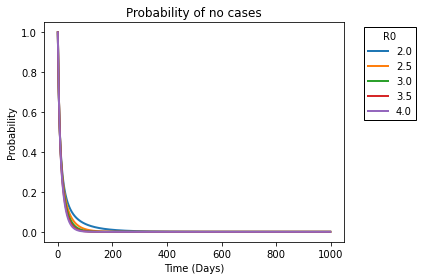

In [6]:
# Solve ODEs 

rho_mat = np.zeros((len(Reff_vec), len(time)))
q_mat = np.zeros_like(rho_mat)
R_vec = np.zeros_like(Reff_vec)
cmp = plt.cm.get_cmap('Set2')

showplot_rho = -1
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
#     beta_vec = beta_SA * prop_vec
    RV = Reff*rtrans_variant

    
    omega_vec = sigma * np.ones(ntypes) 
    if cluster_im:
        omega_vec = np.append(cluster_rate, omega_vec)
    
    for nex in range(0, nexposed):
        omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        
    def omega(t): # Return vector of lifetimes for each state
        return omega_vec

    def P(u, t): # Offspring distribution

        pvec = np.zeros_like(u)
        nexposed = int(ntypes/2)
        omega = (np.sum(prop_vec * const_vec * beta_SA) + gamma)
        
        if cluster_im:
            omega0 = np.sum(prop_vec*const_vec*cluster_size)
            pvec[0] = np.sum((prop_vec*const_vec)*(1+((cluster_size)/alpha)*(1-u[1:(nexposed+1)]))**(-alpha))
            sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*u[1:(nexposed + 1)])
        else:
            sum_gen_funcs = np.sum((beta_SA*prop_vec/omega)*const_vec*u[:nexposed])
        # Can optimise ordering here 
        for nex in range(0, nexposed):
            if cluster_im:
                
                pvec[nex+1] = u[nex+nexposed+1] 
                pvec[nex+nexposed+1] =  u[nex+nexposed+1] * sum_gen_funcs + (gamma/omega)
            else:
                
                pvec[nex] = u[nex+nexposed] 
                pvec[nex+nexposed] =  u[nex+nexposed] * sum_gen_funcs + (gamma/omega)
        
        
        return pvec            
            
            
    def eta(t):
        return im_vec.astype(float)
    ics = np.zeros(ntypes+1)
    ics[-1] = 1.
#     ics[0] = 1.
    n0vec = np.zeros(ntypes)
#     n0vec[0] = 1


    offspring = P
    outbreak = MTBP_extinct(offspring)
    outbreak.set_lifespans(omega)
    outbreak.set_immigration(eta)
    rho = outbreak.solve_odes(outbreak.set_odes, time, ics, n0vec, Full = True) # Solve ODEs for probabilities of extinction/zero
    q_mat [r, :] = rho[0, :]
    rho_mat[r, :] = rho[-1, :] # Take 0th row for qs, -1th row for rs

    plt.plot(time[:showplot_rho], rho_mat[r, :showplot_rho], lw=2, label = str(np.round(RV, 2)))

plt.title("Probability of no cases" )
plt.xlabel("Time (Days)")
plt.ylabel("Probability")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./pnocases_im=" + str(im) + "_n0=0.pdf")


/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/4049607139.py:51: RuntimeWarning: divide by zero encountered in log
  plt.plot(time[:showplot], np.log(mean[r, :showplot]), lw = 2, label = str(np.round(RV, 2)))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/4049607139.py:51: RuntimeWarning: divide by zero encountered in log
  plt.plot(time[:showplot], np.log(mean[r, :showplot]), lw = 2, label = str(np.round(RV, 2)))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/4049607139.py:51: RuntimeWarning: divide by zero encountered in log
  plt.plot(time[:showplot], np.log(mean[r, :showplot]), lw = 2, label = str(np.round(RV, 2)))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/4049607139.py:51: RuntimeWarning: divide by zero encountered in log
  plt.plot(time[:showplot], np.log(mean[r, :showplot]), lw = 2, label = str(np.round(RV, 2)))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/4049607139.py:51: RuntimeWarning

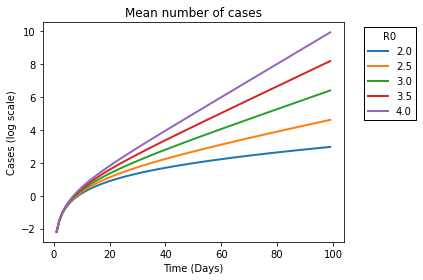

In [11]:
# Mean over time 
# Reff_vec = np.linspace(1.22, 2.94, num=8)
mean_cond = np.zeros((len(Reff_vec), len(time)))
plot_log = 1
if discount_imports:
    mean_arr = np.zeros((len(Reff_vec), ntypes-1, len(time)))
else:
    mean_arr = np.zeros((len(Reff_vec), ntypes, len(time)))
    
mean = np.zeros_like(mean_cond)
showplot = 100
for r, Reff in enumerate(Reff_vec):
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant
    
    
    def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
            Omat = np.zeros((ntypes, ntypes))
            omega_vec = sigma * np.ones(ntypes)       
            if cluster_im:
                omega_vec[0] = np.sum(const_vec*prop_vec*cluster_size)
                for nex in range(0, nexposed):
                    Omat[0, nex+1] = const_vec[nex]*prop_vec[nex]*cluster_size
                    omega_vec[nex + nexposed+1] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                    Omat[nex+1, nex+nexposed+1] = omega_vec[nex+1]
                    Omat[nex+nexposed+1, 1:(nexposed+1)] = const_vec*prop_vec*beta_SA 
                    Omat[nex+nexposed+1, nex+nexposed+1] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)
            else:
                for nex in range(0, nexposed):
                    omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                    Omat[nex, nex+nexposed] = omega_vec[nex]
                    Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
                    Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)

            return Omat
    outbreak.set_Omega(Omega)
    n0s = np.zeros(ntypes)
#     n0s[0] = 1.
    if discount_imports:
        Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s)[1:, :]
    else:
        Mvec = outbreak.solve_mean_odes(outbreak.set_mean_odes, time, n0s)
    mean_arr[r, :, :] = Mvec

    mean[r, :] = np.sum(Mvec, axis=0)
    if plot_log:
        plt.plot(time[:showplot], np.log(mean[r, :showplot]), lw = 2, label = str(np.round(RV, 2)))
    else:
        plt.plot(time[:showplot], mean[r, :showplot], lw = 2, label = str(np.round(RV, 2)))


if plot_log:
    plt.title("Mean number of cases" )
    plt.ylabel("Cases (log scale)")
else:
    plt.title("Mean number of cases" )
    plt.ylabel("Cases")
    
plt.xlabel("Time (Days)")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./meancases_im=" + str(im) + "plotlog=" + str(plot_log) + "_n0=0.pdf")




In [7]:
def invert_mat_safe(A): # We don't use this any more but it's useful to have
    P, L, U = sp.linalg.lu(A.copy())
    I = np.identity(len(A.copy()))
    Psys = sp.linalg.solve(P, I)
    Lsys = sp.linalg.solve_triangular(L, Psys, lower = True)
    Usys = sp.linalg.solve_triangular(U, Lsys)
    return Usys

scale = const_vec*prop_vec


In [8]:
if cluster_im:
    def Omega_sym(t):
        a, b, c, d, s, g, beta, k = sym.symbols('a b c d s g beta k')
        sum1 = a + b + c + d
        Omat = sym.Matrix([[-sum1*k, 0, 0, 0, sum1*k, 0, 0, 0, 0],
                         [0, -s, 0, 0, 0, s, 0, 0, 0], 
                         [0, 0, -s, 0, 0, 0, s, 0, 0], 
                         [0, 0, 0, -s, 0, 0, 0, s, 0], 
                         [0, 0, 0, 0, -s, 0, 0, 0, s],
                          [0, a*beta, b*beta, c*beta, d*beta, -g, 0, 0, 0],
                          [0, a*beta, b*beta, c*beta, d*beta, 0, -g, 0, 0],
                          [0, a*beta, b*beta, c*beta, d*beta, 0, 0, -g, 0],
                          [0, a*beta, b*beta, c*beta, d*beta, 0, 0, 0, -g]]
                         )
        return Omat
    
else:
    def Omega_sym(t):
        a, b, c, d, s, g, beta = sym.symbols('a b c d s g beta')
        Omat = sym.Matrix([[-s, 0, 0, 0, s, 0, 0, 0], 
                         [0, -s, 0, 0, 0, s, 0, 0], 
                         [0, 0, -s, 0, 0, 0, s, 0], 
                         [0, 0, 0, -s, 0, 0, 0, s],
                          [a*beta, b*beta, c*beta, d*beta, -g, 0, 0, 0],
                          [a*beta, b*beta, c*beta, d*beta, 0, -g, 0, 0],
                          [a*beta, b*beta, c*beta, d*beta, 0, 0, -g, 0],
                          [a*beta, b*beta, c*beta, d*beta, 0, 0, 0, -g]]
                         )
        return Omat

# gamma = 1/7 # Recovery Rate
# sigma = 1/2 # Progression rate from exposed to infectious



def eigvls_sym(params, offspring):
    evals = offspring(0).diagonalize()[1]
    return np.diag(np.array(evals.subs(params)).astype(np.float64))

def eigvects_sym(params, offspring, norm = True):
    evects = offspring(0).diagonalize()[0]
    evects = np.array(evects.subs(params)).astype(np.float64)
    if norm:
        for j in range(0, np.shape(evects)[1]):
            evects[:, j] /= np.sqrt(np.sum(evects[:, j]**2))
    return evects

def reorder_evecs(eigenvalues, eigenvectors, ordering):
    eigenvalues_new = np.asarray([eigenvalues[j] for j in ordering])
    eigenvectors_new = np.asarray([eigenvectors[:,j] for j in ordering]).T
    return eigenvalues_new, eigenvectors_new


In [9]:
# Variance  - for highest R0 (or single value to be chosen)
# Build a vector C from matrix G as in Garden of BPs
# Reff_vec = np.linspace(1.22, 2.94, num=8)
var_vec = np.zeros((len(Reff_vec), len(time)))
lamb_vec = np.zeros(len(Reff_vec)) # Vector of growth rates for each R0
var_mat = np.zeros((len(Reff_vec), len(time), ntypes, ntypes))

for r in range(0, len(Reff_vec)):
    Reff = Reff_vec[r]
    beta_SA = Reff*gamma*rtrans_variant
    RV = Reff*rtrans_variant

    
    # Set lifespan vector for each R0
    omega_vec = sigma * np.ones(ntypes)
    if cluster_im:
        omega_vec[0] = np.sum(const_vec*prop_vec*cluster_size)
        for nex in range(0, nexposed):
            omega_vec[nex + nexposed + 1] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        param_dict = {"a":scale[0], "b":scale[1], "c":scale[2], "d":scale[3], "s":sigma, "g":gamma, "beta":beta_SA, "k":cluster_size}
    else:
        for nex in range(0, nexposed):
            omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
        param_dict = {"a":scale[0], "b":scale[1], "c":scale[2], "d":scale[3], "s":sigma, "g":gamma, "beta":beta_SA}
            
            
    # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
    
    def Omega(t):
            Omat = np.zeros((ntypes, ntypes))
            
            if cluster_im:
                for nex in range(0, nexposed):
                    Omat[0, nex+1] = const_vec[nex]*prop_vec[nex]*cluster_size
                    Omat[nex+1, nex+nexposed+1] = omega_vec[nex+1]
                    Omat[nex+nexposed+1, 1:(nexposed+1)] = const_vec*prop_vec*beta_SA
                    Omat[nex+nexposed+1, nex+nexposed+1] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)
            else:
                for nex in range(0, nexposed):
                    Omat[nex, nex+nexposed] = omega_vec[nex]
                    Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA
                    Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

                Omat -= np.diag(omega_vec)
            return Omat

    eigvls = eigvls_sym(param_dict, Omega_sym)
    orth = eigvects_sym(param_dict, Omega_sym)
    ordering = (np.argsort(eigvls)).tolist()
    eigvls, orth = reorder_evecs(eigvls, orth, ordering)
    
    lamb = np.max(eigvls)
    lamb_vec[r] = lamb
    diagmat = np.diag(eigvls)
    print("Orth condition number is: " +  str(nla.cond(orth)))
    orth_inv = invert_mat_safe(orth.copy())
    
    orth_c = orth.copy().T
    orthc_inv = invert_mat_safe(orth_c.copy())
    
    H = np.kron(orth, np.kron((orthc_inv), orthc_inv))
    Hinv = np.kron(orth_inv, np.kron(orth_c, orth_c)) # Inverse of H - calculate directly
    
    Amat = np.kron(orthc_inv, orthc_inv)
    vec_w = np.zeros(ntypes**3)
    Amat_inv = np.kron(orth_c, orth_c)
   
    def Hessian(t, beta): # Hessian of the Offspring Distribution

        Hmat = np.zeros((ntypes, ntypes, ntypes))       
       
        if cluster_im:
            for i in range(1, nexposed+1):
                Hmat[0, i, i] = (const_vec[i-1]*prop_vec[i-1] * (cluster_size**2) * (alpha+1)/alpha)#/np.sum(const_vec*prop_vec*cluster_size)

            for level in range(1, nexposed+1):
                for i in range(1, nexposed+1):

                    Hmat[level + nexposed, level+nexposed, i] = (beta * const_vec[i-1]*prop_vec[i-1])/(omega_vec[level+nexposed-1])
                    Hmat[level + nexposed, i, level+nexposed] = (beta * const_vec[i-1]*prop_vec[i-1])/(omega_vec[level+nexposed-1])

        else:
            for level in range(0, nexposed):
                for i in range(0, nexposed):

                    Hmat[level + nexposed, level+nexposed, i] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])
                    Hmat[level + nexposed, i, level+nexposed] = (beta * const_vec[i]*prop_vec[i])/(omega_vec[level+nexposed])

        return Hmat

    def P_vecs(t, beta): # Essentially the same as Omega matrix - matrix of partial derivatives - columns should be partial derivatives of each P_i(s)

        Omat = np.zeros((ntypes, ntypes))
        if cluster_im:
            for nex in range(0, nexposed):
                Omat[nex+1, 0] = const_vec[nex]*prop_vec[nex]*cluster_size
                Omat[nex+1, nex+nexposed+1] = omega_vec[nex+1]/omega_vec[nex+1]
                Omat[nex+nexposed+1, 1:(nexposed+1)] = const_vec*prop_vec*beta_SA/omega_vec[nex+nexposed+1]
                Omat[nex+nexposed+1, nex+nexposed+1] = np.sum(const_vec * beta_SA * prop_vec)/omega_vec[nex+nexposed+1]

        else:
            for nex in range(0, nexposed):
                Omat[nex, nex+nexposed] = omega_vec[nex]/omega_vec[nex]
                Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA/omega_vec[nex+nexposed]
                Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)/omega_vec[nex+nexposed]

        return Omat.T # This is correct - you want *columns* to be the derivatives of each P_i 

    # Compose Gmat

    Gmat = np.zeros((ntypes, ntypes, ntypes))
    C = np.zeros(ntypes**3)

    Pmat = P_vecs(0, beta_SA)    
    for l in range(0, ntypes):

        Gmat[l, :, :] = Hessian(0, beta_SA)[l, :, :] + np.diag(Pmat[:, l]) - np.outer(Pmat[:, l], Pmat[:, l])
        unitvec = np.zeros(ntypes)
        unitvec[l] = 1
        Gmat[l, :, :] += np.outer(unitvec, unitvec) + np.outer(Pmat[:, l], Pmat[:, l]) - np.outer(unitvec, Pmat[:, l]) - np.outer(Pmat[:, l], unitvec)
        Gmat[l, :, :] *= omega_vec[l]
        C[l*ntypes*ntypes:(l+1)*ntypes*ntypes] = Gmat[l, :, :].flatten('F') # Stack columns for 'vec' operator
    HinvC = Hinv @ C

    def Deltamat(t, eigenvalues):
        dmat = np.diag(eigenvalues)
        kp = np.kron(dmat, np.identity(ntypes)) + np.kron(np.identity(ntypes), dmat) # kronecker product
        kp_inv = nla.inv(kp)
        integral = (sp.linalg.expm(kp*t) - sp.linalg.expm(kp*0))@kp_inv
        return integral

    def Deltamat_im(t, eigenvalues):
        dmat = np.diag(eigenvalues)
        dmat_inv = nla.inv(dmat)
        kp = np.kron(dmat, np.identity(ntypes)) + np.kron(np.identity(ntypes), dmat) # kronecker product
        kp_inv = nla.inv(kp)
        idn = np.identity(ntypes)
        dkron = np.kron(-dmat, np.identity(ntypes**2)) + np.kron(idn, kp)
        dkron_inv = nla.inv(dkron)
        integral_1 = np.kron(idn, (sp.linalg.expm(t*kp) - sp.linalg.expm(0*kp))@kp_inv)@dkron_inv
        integral_2 = np.kron((sp.linalg.expm(t*dmat) - idn)@dmat_inv, np.kron(idn, idn))@dkron_inv
        integral = integral_1 - integral_2
        return integral


    # Build both components for variance with immigration from eq. 21 and final eq. on p.213
    
    def var(t):
        vec_w = np.zeros(ntypes**3)
        vec_v = np.zeros(ntypes**3) 
        Dmat_im = Deltamat_im(t, eigvls)
#         Dmat_im = t*np.identity(ntypes**3)
        vecvar = H @ Dmat_im  @ HinvC
        Dmat = Deltamat(t, eigvls)
        
        
        # Whatever is going wrong is common to both components - eigenvalues/vectors essentially ruled out
        
        for i in range(0, ntypes):
            
            unitvec = np.zeros(ntypes)
            unitvec[i] = 1.
            
            vecvar_i = im_vec[i] * np.kron(unitvec, np.kron(np.identity(ntypes), np.identity(ntypes))) @ vecvar
#             vecvar_i =  vecvar

            unit_outer_prod = np.outer(unitvec, unitvec).flatten() # Stack columns for 'vec' operator
            vec_wi =  im_vec[i] * (Amat @ Dmat @ Amat_inv @ unit_outer_prod)
            
            
            
            vec_w[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vec_wi
            vec_v[i*ntypes*ntypes:(i+1)*ntypes*ntypes] = vecvar_i
            
        v = np.reshape(vec_v, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)
        w = np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)

        v += w
        return v # np.reshape(vec_w, (ntypes, ntypes, ntypes)).transpose(0, 2, 1)

   
    T=0
    for Time in tqdm(time):
        if cluster_im:
            if discount_imports:
                var_time = var(Time)
                var_vec[r, T] = np.sum(var_time[:, 1:, 1:])
                var_mat[r, T, :, :] = np.sum(var_time[:, 1:, 1:], axis = 0)
            else:
                var_time = var(Time)
                var_vec[r, T] = np.sum(var_time)
                var_mat[r, T :, :] = np.sum(var_time, axis = 0)
        else:
            var_time = var(Time)
            var_vec[r, T] = np.sum(var_time)
            var_mat[r, T, :, :] = np.sum(var_time, axis = 0)
        T+=1

Orth condition number is: 5.786890201250823


100%|███████████████████████████████████████| 1000/1000 [00:22<00:00, 45.45it/s]


Orth condition number is: 5.712729223114732


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.16it/s]


Orth condition number is: 5.654689818290059


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 45.87it/s]


Orth condition number is: 5.608041520271007


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.11it/s]


Orth condition number is: 5.569859764889624


100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 45.94it/s]


In [12]:
tstars = np.zeros(len(Reff_vec))
if cluster_im:
    mean_stars = np.zeros((len(Reff_vec), ntypes-1))
else:
    mean_stars = np.zeros((len(Reff_vec), ntypes))
tstar_idxs = np.zeros(len(Reff_vec))
Istar = 100
for r, Reff in enumerate(Reff_vec):
    if mean[r, -1]>=Istar:
        tstar_idx  = np.min(np.where(mean[r, :] >= Istar)[0])
        tstar_idxs[r] = tstar_idx
        tstar = time[tstar_idx]
        mean_stars[r, :] = mean_arr[r, :, tstar_idx]
    else:
        tstar = np.nan
    tstars[r] = tstar
tstar_idxs = tstar_idxs.astype(int)
tstar_idxs

array([220,  99,  70,  55,  47])

/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1173084964.py:5: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1173084964.py:5: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1173084964.py:5: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1173084964.py:5: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1173084964.py:5: RuntimeWarning: invalid value encountered in true_divide
  sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1173084964.

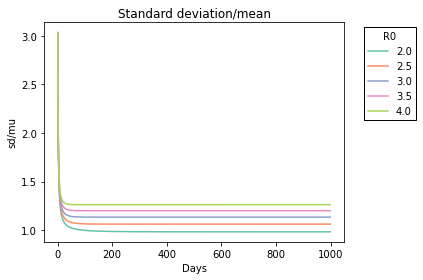

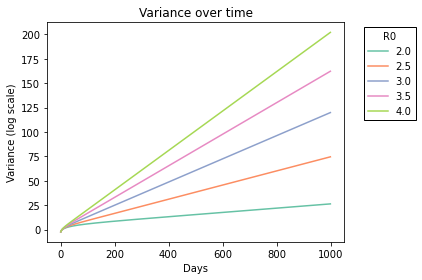

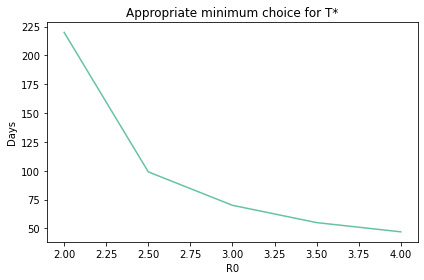

In [13]:
sig_vec= np.sqrt(var_vec)
sns.set_palette("Set2")
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    sig_over_mean = (sig_vec[r, :]/(mean[r, :]))
#     sig_over_mean = (sig_vec[r, :]/(mean_cond[r, :] ))
    plt.plot(time, sig_over_mean , label = str(RV))
plt.title("Standard deviation/mean")
plt.ylabel("sd/mu")
plt.xlabel("Days")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./sd_over_mean_plot.pdf")

plt.figure()
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    plt.plot(time[:], np.log(var_vec[r, :]), label = str(RV))
plt.title("Variance over time")
plt.ylabel("Variance (log scale)")
plt.xlabel("Days")
plt.legend(loc=2, bbox_to_anchor=(1.05, 1), framealpha=1., edgecolor='black', fancybox=False, title = "R0")
plt.tight_layout()
if save:
    plt.savefig("./variance_plot.pdf")

# Plot T^star for each R0

tol = 1e-4

Tstars = np.zeros(len(Reff_vec))
Tstar_idx = np.zeros(len(Reff_vec)).astype(int)
for r in range(0, len(Reff_vec)):
    sig_over_mean = (sig_vec[r, :])/(mean[r, :])
    diff = np.gradient(sig_over_mean)
    try:
        Tstar_idx1 = (np.min(np.where(np.abs(diff[15:])<=tol)[0]))
    except:
        Tstar_idx1 = 0
    Tstar_idx[r] = np.max((Tstar_idx1, tstar_idxs[r]))
    Tstars[r] = time[Tstar_idx[r]]
plt.figure()
plt.plot(Reff_vec*rtrans_variant, Tstars)
plt.title("Appropriate minimum choice for T*")
plt.xlabel("R0")
plt.ylabel("Days")
plt.tight_layout()

if save:
    plt.savefig("./tstarchoice.pdf")
    

In [13]:
tstar_idxs

array([220,  99,  70,  55,  47])

/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1975855918.py:36: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color, label = "Coeff. of variation")
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1975855918.py:40: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1975855918.py:40: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipykernel_3336/1975855918.py:40: RuntimeWarning: invalid value encountered in true_divide
  ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
/var/folders/z6/sfzmy5f15zj2c78mb7pnt1sr0000gn/T/ipyk

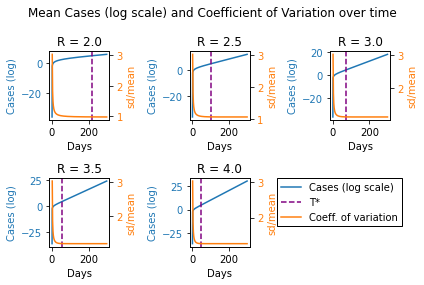

In [14]:
np.hstack((Tstars, tstars))
time[Tstar_idx]
threshold = 100
Istars_min = np.zeros_like(Tstar_idx)
tst_idx = np.zeros_like(Tstar_idx)
for r in range(0, len(Reff_vec)):
    Istars_min[r] = mean[r, Tstar_idx[r]]
#     tst_idx[r] = np.min(np.where(mean[r, :]>=threshold))

showplot = 300

fig, axs = plt.subplots(2, 3)
for r in range(0, len(Reff_vec)):
    RV = np.round(Reff_vec[r]*rtrans_variant, 2)
    if r<=2:
        b = 0
    else:
        b=1    
    color = 'tab:blue'
    if r ==0:
        
        axs[b, r%3].plot(time[:showplot], np.log(mean[r, :showplot] + np.finfo(float).eps) , color = color, label = "Cases (log scale)")
    else:
        axs[b, r%3].plot(time[:showplot], np.log(mean[r, :showplot] + np.finfo(float).eps) , color = color)
        axs[b, r%3].axvline(time[Tstar_idx[r]], color = 'purple', linestyle = '--')
    axs[b, r%3].tick_params(axis='y', labelcolor=color)
    
    axs[b, r%3].set_ylabel("Cases (log)", color = color)
    axs[b, r%3].set_ylabel("Cases (log)", color = color)
    axs[b, r%3].set_xlabel("Days")
    axs[b, r%3].set_title("R = " + str(RV))
    axs[-1, -1].set_visible(False)
    color= 'tab:orange'
    ax1 = axs[b, r%3].twinx()
    if r ==0:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color, label = "Coeff. of variation")
        axs[b, r%3].axvline(time[Tstar_idx[r]], color = 'purple', linestyle = '--', label = str("T*"))

    else:
        ax1.plot(time[:showplot], (sig_vec[r, :showplot])/(mean[r, :showplot] ), color = color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel("sd/mean", color = color)
    
    
    
bottom_right_ax = axs[-1][-1] 
bottom_right_ax.clear()  
bottom_right_ax.set_axis_off()
plt.suptitle("Mean Cases (log scale) and Coefficient of Variation over time")
fig.legend(loc='lower right', bbox_to_anchor=(0.95, 0.2),framealpha=1., edgecolor='black', fancybox=False)
fig.tight_layout()
if save:
    plt.savefig("sig_over_mean_plot.pdf")

In [15]:
Istars_min

array([100, 100, 106, 101, 107])

100%|███████████████████████████████████████| 1000/1000 [01:10<00:00, 14.09it/s]


DescribeResult(nobs=1000, minmax=(array([1.]), array([54.])), mean=array([5.88]), variance=array([50.9985986]), skewness=array([2.32475447]), kurtosis=array([6.71813269]))

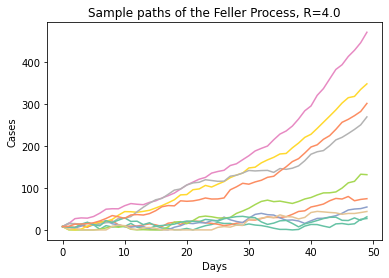

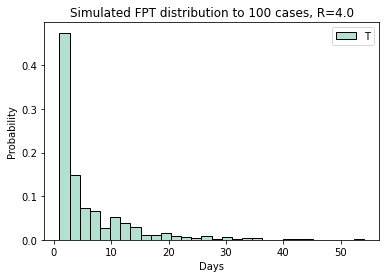

In [45]:
idx = 4
cmap = sns.color_palette('Set2')
beta_SA = Reff_vec[idx]*gamma*rtrans_variant
np.random.seed(1)
def EulerMaruyama(mu, sigma, dW, t0, y0, dt=1, num_its = len(time)):
    t = t0
    y = np.zeros((ntypes, num_its))
    
    y[:, 0] = y0
    for i in range(1, num_its):
        yn = y[:, i-1] + (mu(y[:, i-1], t))*dt + sigma(y[:, i-1], t) * dW(dt)
        for j, ynn in enumerate(yn):
            if ynn > 0:
                y[j, i] = ynn
            else:
                y[j, i] = 0
        t += dt

    return y

def drift(y, t):
    return lamb_vec[idx]*y + im

def s(y, t):
    return np.sqrt(((beta_SA + gamma))*y)
    

def dW(t):
    return np.random.normal(loc=0.0, scale=np.sqrt(t))


def drift1(y, t):
    return (Omega(0)/2)@y#(lamb_vec[idx]/2)*y

def s1(y, t):
    return np.sqrt((beta_SA+gamma)/2)#(np.sum(const_vec*prop_vec*beta_SA) + gamma)/2 

# def EulerMaruyama(mu, sigma, dW, t0, y0, dt=1, num_its = len(time)):
#     t = t0
#     y = np.zeros((len(y0), num_its))
    
#     y[:, 0] = y0
#     for i in range(1, num_its):
        
#         yn = y[:, i-1] + (mu(y[:, i-1], t) + im_vec)*dt + sigma(y[:, i-1], t) * dW(dt)
#         for j, ynn in enumerate(yn):
#             if ynn <=0:
#                 yn[j] = 0
# #         if yn.all() > 0:
        
#         y[:, i] = yn
# #         else:

# #             if ynn>0:
# #                 y[j, i] = ynn
# #             y[yn<=0, i] = 0
#         if np.sum(y[:, i] >= Istars_min[idx]):
#             break
#         t += dt

#     return y

n_sims = 1000
n_plots = int(n_sims/10)
dt = np.diff(time)[0]
plt.figure(10)
stop_time = Tmax
show_time = 50
stop_times = np.zeros(n_sims)
stop_times1 = np.zeros_like(stop_times)
for i in tqdm(range(n_sims)):
#     feller_simulation = EulerMaruyama(drift, s, dW, time[0], 0, dt, num_its = stop_time)
    feller_simulation_root = np.sum(EulerMaruyama(drift1, s1, dW, time[0], np.ones(ntypes), dt, num_its = stop_time), axis = 0)
    try:
#         time_idx = np.min(np.where(feller_simulation>= Istars_min[idx])[0])
        time_idx1 = np.min(np.where(feller_simulation_root>= np.sqrt(mean[idx, tstar_idxs[idx]])))
#         time_idx = np.min(np.where(feller_simulation>= 1000)[0])
    except:
#         time_idx = 0
        time_idx1 = 0
#     stop_times[i] = time[time_idx]
    stop_times1[i] = time[time_idx1]
#     print(feller _simulation)
    if i%n_plots ==0:
        plt.plot(time[:show_time], feller_simulation_root[:show_time])
plt.title("Sample paths of the Feller Process, R=" + str(Reff_vec[idx]))
plt.ylabel("Cases")
plt.xlabel("Days")
plt.savefig("Feller_sample_paths_R=" + str(Reff_vec[idx]) + ".pdf")
plt.figure(11)
df = pd.DataFrame(stop_times1, columns = ["T"])
df= df[df['T'] != 0]
sns.histplot(df, stat = "probability", color = cmap[1], bins = 30)
plt.title("Simulated FPT distribution to 100 cases, R=" + str(Reff_vec[idx]) )
plt.xlabel("Days")
plt.savefig("Feller_sim_FPT_R=" + str(Reff_vec[idx]) + ".pdf")
sp.stats.describe(df)


In [47]:
idx = 4
Reff = Reff_vec[idx]
beta_SA = Reff*gamma*rtrans_variant
RV = Reff*rtrans_variant
lamb = lamb_vec[idx]

def Omega(t): # Matrix of first partial derivatives of offspring distribution minus lifetimes*identity
        Omat = np.zeros((ntypes, ntypes))
        omega_vec = sigma * np.ones(ntypes)       
        if cluster_im:
            omega_vec[0] = np.sum(const_vec*prop_vec*cluster_size)
            for nex in range(0, nexposed):
                Omat[0, nex+1] = const_vec[nex]*prop_vec[nex]*cluster_size
                omega_vec[nex + nexposed+1] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                Omat[nex+1, nex+nexposed+1] = omega_vec[nex+1]
                Omat[nex+nexposed+1, 1:(nexposed+1)] = const_vec*prop_vec*beta_SA 
                Omat[nex+nexposed+1, nex+nexposed+1] = np.sum(const_vec * beta_SA * prop_vec)

            Omat -= np.diag(omega_vec)
        else:
            for nex in range(0, nexposed):
                omega_vec[nex + nexposed] = np.sum(const_vec*prop_vec*beta_SA) + gamma
                Omat[nex, nex+nexposed] = omega_vec[nex]
                Omat[nex+nexposed, :nexposed] = const_vec*prop_vec*beta_SA 
                Omat[nex+nexposed, nex+nexposed] = np.sum(const_vec * beta_SA * prop_vec)

            Omat -= np.diag(omega_vec)

        return Omat
# test_vec = np.append(const_vec*prop_vec*beta_SA - sigma, (sigma - gamma)*np.ones(nexposed))


Om = Omega(0)
def gp_var(u, t):
    t_idx = int(t)
    if t_idx == Tmax:
        t_idx -= 1
#     Avec = np.zeros(ntypes)
#     for i in range(nexposed):
#         Avec[i] = np.sum(const_vec*prop_vec*beta_SA*u[nexposed:])-sigma*u[i]
#         Avec[i+nexposed] = sigma*u[i] - gamma[i+nexposed]
    return (2*(lamb)*u) + ((gamma + beta_SA))
#     return -(Om@u  + u@Om.T) + np.sum(var(t), axis = 0)
#     return (Om@u  ) + np.sum(var(t), axis = 0)



A0 = np.zeros((ntypes, ntypes))
# gp_Ci = ForwardEuler(gp_var)
# gp_Ci.set_ic(A0)
# gp_Ci_sol, time_ignore = gp_Ci.solver(time)
# gp_C[i, :, :] += gp_Ci_sol

sol = odeintw(gp_var, A0, time)
def gp_mean(u, t):
#     return (lamb)*u + im_vec
    return (Om)@u 


def alpha_chi(t):
    return 4*im/((1 - np.exp(-t))*(beta_SA+gamma)**2)

def delta_chi(t):
    return 4*im*1*(1-np.exp(-t))/np.exp(-t)

nu_chi = 4*(im/(beta_SA+gamma))**2
    
    
    
    
m0 = np.zeros(ntypes)
gp_mu = sp.integrate.odeint(gp_mean, m0, time)
gp_mu = np.sum(gp_mu, axis = 1)

# t_idx = np.min(np.where(np.sqrt(mean[idx, :]) >= np.sqrt(Istars_min[idx])))

t_idx = np.min(np.where(gp_mu >= Istars_min[idx])[0])
# t_idx = tstar_idxs[idx]
cdf = np.zeros_like(time).astype(float)
for t_idx, T in enumerate(time):
#     normal_samples = np.random.normal(gp_mu[t_idx], np.sqrt(np.sum(sol[t_idx,:,:])), size = normal_size)
    
#     prob = len(np.where(normal_samples >= Istars_min[idx])[0])#/normal_size
    prob = 1-sp.stats.norm(gp_mu[t_idx], np.sqrt(np.sum(sol[t_idx,:,:]))).cdf(Istars_min[idx])
#     prob = 1-sp.stats.ncx2(2*(beta_SA+gamma)/im, delta_chi(t)).cdf((im)/(2*(beta_SA-gamma))*(1-np.exp((gamma-beta_SA)*T)))
#     print(prob)
    try:
#         print(prob)
        cdf[t_idx] = prob
#         print(cdf)
    except:
        
        cdf[t_idx] = 0
    
# cdf = cdf/normal_size 
# normal = pd.DataFrame(normal_samples)
pdf = np.gradient(cdf)
plt.plot(time[:150], pdf[:150], color = 'r', label = "Gaussian Approximated FPT")

sns.histplot(df, stat = 'density', label = "Feller Simulated FPT")
# sns.ecdfplot(df, stat = 'proportion', label = "Feller Simulated FPT")
plt.legend()


ValueError: zero-size array to reduction operation minimum which has no identity

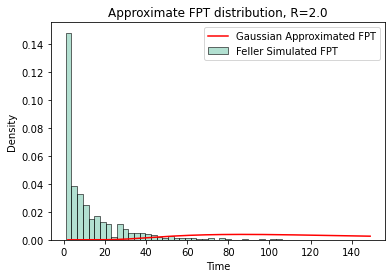

In [40]:
plt.plot(time[:150], pdf[:150], color = 'r', label = "Gaussian Approximated FPT")

sns.histplot(df, stat = 'density', label = "Feller Simulated FPT")
# sns.ecdfplot(df, stat = 'proportion', label = "Feller Simulated FPT")
plt.xlabel("Time")
plt.title("Approximate FPT distribution, R=" + str(Reff_vec[idx]))
plt.legend()
# plt.savefig("Gauss_test_R=" +str(RV) +  ".pdf")

<AxesSubplot:ylabel='Proportion'>

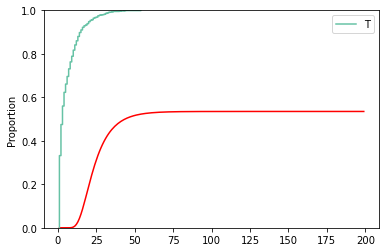

In [46]:
plt.plot(time[:200], cdf[:200], color = 'r', label = "Gaussian Approximated FPT")

sns.ecdfplot(df, stat = 'proportion', label = "Feller Simulated FPT")

In [566]:
# idx = 0
# RV = Reff_vec[idx]*rtrans_variant
# t_idx = np.max((Tstar_idx[idx], tstar_idxs[idx]))
# tval = np.max((Tstar_idx[idx], tstar_idxs[idx]))
# # tval = Tstar_idx[idx]

# growth_rate = lamb_vec[idx]
# varnew = var_vec[idx, tval]
# Istars = np.array((Istars_min[idx], tstars[idx]))
# Istar = np.max(Istars[~np.isnan(Istars)])
# tstar = time[tval]
# # Istar = Istars_min[idx]
# sd = np.sqrt(varnew)

# nu = np.log(Istar)


# # 
# # wald = np.random.wald(Istar, varnew, size=10000)
# wald = np.random.wald(tstar, nu**2/((sd/(Istar))**2), size=10000)
# df = pd.Series(np.log(wald), name = "Days")

# # sns.distplot(df, stat = "density")
# # sns.kdeplot(df, color = "orange") 
# # sns.distplot(wald, kde_kws = {"color": "g"})
# # sns.set_palette("Accent")
# cmap = sns.color_palette("Accent")
# sns.histplot(wald, stat = "probability", color = cmap[1])

# # sns.kdeplot(wald, color = cmap[4])
# plt.xlim(0, 200)
# plt.xlabel("Days")
# plt.title("Time to Successful Establishment of VoC, R0 = " + str(RV))
# plt.xlim((0, 200))
# save = 0
# if save:
#     plt.savefig("./time_distplot_R0=" + str(RV) + ".pdf")
#     plt.savefig("./time_distplot_R0=" + str(RV) + ".png")
#     plt.savefig("./time_distplot_R0=" + str(RV) + ".jpeg")
# # plt.savefig("./time_distplot_alternative_R0=" + str(RV) + ".pdf")
# sp.stats.describe(wald)


R = 2.0 has mean 220.0508243759772, median 217.56631728982723 days to introduction.
R = 2.5 has mean 100.00587349400028, median 99.5859069498116 days to introduction.
R = 3.0 has mean 105.99478866035311, median 105.60223310060101 days to introduction.
R = 3.5 has mean 101.01729213742745, median 100.65928146989246 days to introduction.
R = 4.0 has mean 106.99626166686274, median 106.67759705536359 days to introduction.


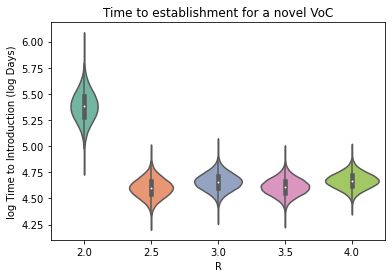

In [184]:
# total_df = pd.DataFrame(columns = ["TimeToIntroduction", "R"])
# sample_size= 100000
# T_idxs = np.zeros(len(Reff_vec))
# for idx in range(0, len(Reff_vec)):

#     RV = Reff_vec[idx]*rtrans_variant
#     t_idx = np.max((Tstar_idx[idx], tstar_idxs[idx]))
#     tval = np.max((Tstar_idx[idx], tstar_idxs[idx]))
# #     tval = Tstar_idx[idx]
#     T_idxs[idx] = t_idx
#     varnew = var_vec[idx, tval]
#     Istars = np.array((Istars_min[idx], tstars[idx]))
#     Istar = np.max(Istars[~np.isnan(Istars)])

# #     Istar = Istars_min[idx]
#     sd = np.sqrt(varnew)

#     nu = np.log(Istar)


#     time[tval]
#     wald = np.random.wald(Istar, varnew, size=sample_size)
# #     wald = np.random.wald(tval, (nu**2/((sd/(Istar))**2)), size=sample_size)
# #     wald = np.random.lognormal(np.log(Istar), np.log(sd/2), size = sample_size)
#     print("R = " + str(RV) + " has mean " + str(np.mean(wald)) + ", median " + str(np.median(wald)) + " days to introduction.")
#     wald=np.log(wald)
#     # wald = np.random.wald(time[tval], sd, size=10000)
#     df_idx = pd.DataFrame(np.vstack((wald, RV*np.ones(sample_size))).T, columns = ["TimeToIntroduction", "R"])
#     total_df = pd.concat([total_df, df_idx], axis=0)

# sns.violinplot(x="R", y="TimeToIntroduction", data = total_df)
# plt.ylabel("log Time to Introduction (log Days)")
# plt.title("Time to establishment for a novel VoC")
# T_idxs=T_idxs.astype(int)
# save = 0
# if save:
#     plt.savefig("violin_plot.pdf")
# # plt.ylim([-50, 200])

In [54]:
beta_test = 0.55
gamma_test = 0.5

def EulerMaruyama_single(mu, sigma, dW, t0, y0, dt=1, num_its = len(time)):
    t = t0
    y = np.zeros(num_its)
    
    y[0] = y0
    for i in range(1, num_its):
        yn = y[i-1] + (mu(y[i-1], t))*dt + sigma(y[i-1], t) * dW(dt)
        if yn > 0:
            y[i] = yn
        else:
            y[i] = 0
        t += dt

    return y


def drift_test(y, t):
    return ((beta_test-gamma_test)/2)*y

def s_test(y, t):
    return np.sqrt((beta_test + gamma_test)/2)

def drift_test1(y, t):
    return ((beta_test-gamma_test))*y + im

def s_test1(y, t):
    return np.sqrt((beta_test + gamma_test) * y)


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.38it/s]


DescribeResult(nobs=1000, minmax=(array([10.]), array([437.])), mean=array([76.976]), variance=array([2726.19161562]), skewness=array([1.93754911]), kurtosis=array([5.67721467]))
DescribeResult(nobs=1000, minmax=(array([10.]), array([437.])), mean=array([76.976]), variance=array([2726.19161562]), skewness=array([1.93754911]), kurtosis=array([5.67721467]))


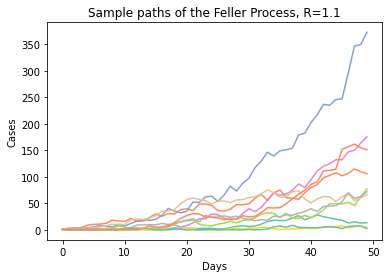

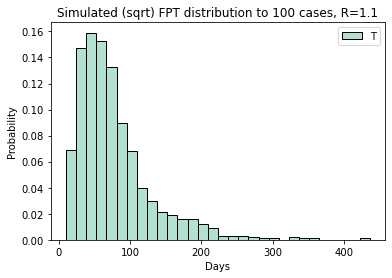

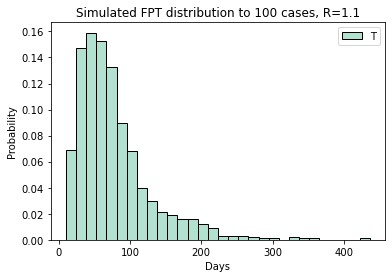

In [71]:
np.random.seed(123)
n_sims = 1000
n_plots = int(n_sims/10)
dt = np.diff(time)[0]
plt.figure(10)
stop_time = Tmax
show_time = 50
stop_times = np.zeros(n_sims)
stop_times1 = np.zeros_like(stop_times)
for i in tqdm(range(n_sims)):
    feller_simulation = EulerMaruyama_single(drift_test, s_test, dW, time[0], 1, dt, num_its = stop_time)
    feller_simulation1 = EulerMaruyama_single(drift_test1, s_test1, dW, time[0], 1, dt, num_its = stop_time)
    try:
        time_idx = np.min(np.where(feller_simulation>=10)[0])
        time_idx1 = np.min(np.where(feller_simulation1>=100)[0])
    except:
        time_idx = 0
        time_idx1 = 0
    stop_times[i] = time[time_idx]
    stop_times1[i] = time[time_idx1]
    if i%n_plots ==0:
        plt.plot(time[:show_time], feller_simulation1[:show_time])
plt.title("Sample paths of the Feller Process, R=" +  str(beta_test/gamma_test))
plt.ylabel("Cases")
plt.xlabel("Days")
plt.figure(11)
df = pd.DataFrame(stop_times, columns = ["T"])
df= df[df['T'] != 0]
sns.histplot(df, stat = "probability", color = cmap[1], bins = 30)
plt.title("Simulated (sqrt) FPT distribution to 100 cases, R=" + str(beta_test/gamma_test) )
plt.xlabel("Days")



plt.figure(12)
df1 = pd.DataFrame(stop_times, columns = ["T"])
# df1= df1[df1['T'] != 0]
sns.histplot(df1, stat = "probability", color = cmap[4], bins = 30)
plt.title("Simulated FPT distribution to 100 cases, R=" + str(beta_test/gamma_test) )
plt.xlabel("Days")
# plt.savefig("Feller_sim_FPT_R=" + str(Reff_vec[idx]) + ".pdf")
print(sp.stats.describe(df))
print(sp.stats.describe(df1))



/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


DescribeResult(nobs=1000, minmax=(array([10.]), array([437.])), mean=array([76.976]), variance=array([2726.19161562]), skewness=array([1.93754911]), kurtosis=array([5.67721467]))


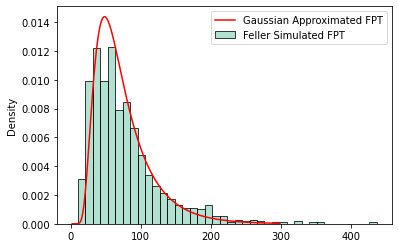

In [72]:
def gp_var_test(u, t):
    t_idx = int(t)
    if t_idx == Tmax:
        t_idx -= 1
    return (((beta_test - gamma_test))*u) + (((gamma_test + beta_test))/2)**2
#     return 2*(beta_test - gamma_test)*u + (gamma_test + beta_test)


A0 = 0
gp0 = 1
sol = sp.integrate.odeint(gp_var_test, A0, time)
def gp_mean_test(u, t):
    return ((beta_test - gamma_test)/2)*u 
#     return ((beta_test - gamma_test))*u + im 

gp_mu = sp.integrate.odeint(gp_mean_test, gp0, time)


# t_idx = np.min(np.where(np.sqrt(mean[idx, :]) >= np.sqrt(Istars_min[idx])))

# t_idx = tstar_idxs[idx]
cdf = np.zeros_like(time).astype(float)
for t_idx, T in enumerate(time):

    prob = 1-(sp.stats.norm(gp_mu[t_idx], (sol[t_idx])**(1/2)).cdf(10))
#     print(prob)
    try:
#         print(prob)
        cdf[t_idx] = prob
#         print(cdf)
    except:
        
        cdf[t_idx] = 0
    
cdf = cdf
# normal = pd.DataFrame(normal_samples)
pdf = np.gradient(cdf)
plt.plot(time[:300], pdf[:300]/cdf[-1], color = 'r', label = "Gaussian Approximated FPT")

sns.histplot(df, stat = 'density', label = "Feller Simulated FPT", bins = 40)
# sns.ecdfplot(df, stat = 'proportion', label = "Feller Simulated FPT")
plt.legend()
print(sp.stats.describe(df))

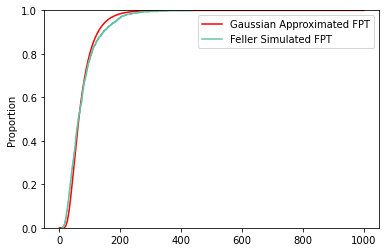

In [64]:
plt.plot(time, cdf/cdf[-1], color = 'r', label = "Gaussian Approximated FPT")

sns.ecdfplot(df, stat = 'proportion', label = "Feller Simulated FPT")
plt.legend()

In [ ]:
def pdf_form(t, b, a, c):
    return b/(a*(np.exp(b*t) - 1)) * np.exp((-b*))
    

<AxesSubplot:ylabel='Count'>

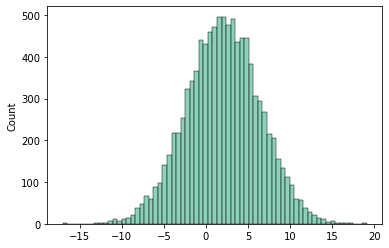

In [68]:
sns.histplot(sp.stats.norm(gp_mu[30], (sol[30])**(1/2)).rvs(size=10000))

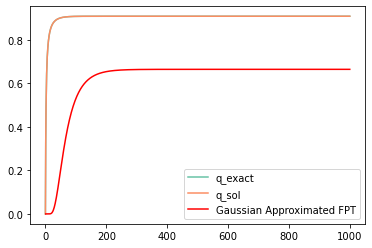

In [63]:
def q_extinct(t):
    c = beta_test/(gamma_test - beta_test)
    exponent = (gamma_test - beta_test)*t
    denominator = c*np.exp(exponent) - c + np.exp(exponent)
    q = 1 - 1/denominator
    return q

def qderiv(u, t):
    return -(beta_test + gamma_test)*u + (beta_test*(u**2) + gamma_test)

plt.plot(time, q_extinct(time), label = "q_exact")
plt.plot(time, sp.integrate.odeint(qderiv, 0, time), label = "q_sol")
plt.plot(time, cdf, color = 'r', label = "Gaussian Approximated FPT")
plt.legend()

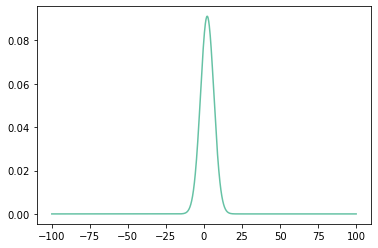

In [67]:
mu = gp_mu[30]
var = sol[30]
x = np.linspace(-100, 100, num = 1000)
normal = 1/np.sqrt(2*np.pi*var) * np.exp(-((x - mu)**2/(2*var)))
plt.plot(x, normal)

In [832]:
np.sqrt(var)/mu

array([2.286082])